<a href="https://colab.research.google.com/github/suinkangme/comp433_project/blob/main/new_comp433_project_sk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Developing a robust CNN model to address the challenge of learning with label noise in  CIFAR10 dataset

- CIFAR10 Label : ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’.

- image size : 3x32x32




In [12]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader
import os
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler

## Load and normalize CIFAR10

- Transform them to Tensors of normalized range [-1, 1].

In [13]:
# train dataset
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
cifar10_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)

Files already downloaded and verified


In [14]:
# validation, test dataset
test_val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [15]:
# extract labels from the dataset
labels = np.array(cifar10_dataset.targets)

train_indices, val_indices = train_test_split(np.arange(len(cifar10_dataset)), test_size=0.2)
train_dataset = torch.utils.data.Subset(cifar10_dataset, train_indices)
val_dataset = torch.utils.data.Subset(cifar10_dataset, val_indices)

In [16]:
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = test_val_transform

In [17]:
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)

In [18]:
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_val_transform)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

Files already downloaded and verified


## Noise Labeling
- 5 different noise levels (10%,
30%, 50%, 80%, 90%)

In [20]:
def apply_label_noise(labels, epsilon, noise_type):
    num_labels = len(labels)
    num_flips = int(epsilon * num_labels)

    if noise_type == 'symmetric':
        # symmetric label noise
        flip_indices = np.random.choice(num_labels, num_flips, replace=False)
        labels[flip_indices] = np.random.randint(0, 10, num_flips)

    elif noise_type == 'asymmetric':
        # asymmetric label noise
        flip_rules = {
            9: 1,   # Truck to Automobile
            2: 0,   # Bird to Airplane
            4: 7,   # Deer to Horse
            3: 5,   # Cat to Dog
            5: 3,   # Dog to Cat
        }

        for i in range(num_labels):
            if np.random.random() < epsilon:
                labels[i] = flip_rules.get(labels[i], labels[i])

    return labels

# Baseline Model

In [21]:
class BaselineModel(nn.Module):
  def __init__(self):
    super(BaselineModel,self).__init__()
    self.features = nn.Sequential(
      nn.Conv2d(3, 8, kernel_size=3, padding = 1),  # (input channel, output channels, kernel size, padding)  32*32*8
      nn.ReLU(inplace=True), # activation function modifies the input tensor directly
      nn.Conv2d(8, 16, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2,stride=2), # 16*16*16

      nn.Conv2d(16, 32, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(32, 64, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(64, 128, kernel_size=3, padding=1),
      nn.MaxPool2d(kernel_size=2,stride=2) # 8*8*128
    )

    # fully connected layers
    self.fc_layers = nn.Sequential(
      nn.Linear(128*8*8, 512),
      nn.ReLU(inplace=True),
      nn.Linear(512,10)
    )

    # apply Xavier initialization to the weights of linear layers
    for m in self.fc_layers:
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)

  def forward(self, x):
    x = self.features(x)
    x = torch.flatten(x,1)
    x = self.fc_layers(x)
    return x

## Train & Validation and Testing - symmetric noise label

In [22]:
# noise levels
noise_levels = [0.1, 0.3, 0.5, 0.8, 0.9]

# create a dictionary with keys in the format 'noise_level_{100 * value}'
model_dict = {f'noise_level_{int(100 * level)}_sy': None for level in noise_levels}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# initialize lists to store metrics
train_losses = {epsilon: [] for epsilon in noise_levels}
train_accuracies = {epsilon: [] for epsilon in noise_levels}
val_losses = {epsilon: [] for epsilon in noise_levels}
val_accuracies = {epsilon: [] for epsilon in noise_levels}
training_times = []
validation_times = []

# training
for epsilon in noise_levels:

    num_epochs = 7

    model = BaselineModel()
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=120)  # Learning rate scheduler (cosine annealing)

    model.train()

    print(f"Symmetric Training with noise level: {epsilon}")

    # initialize variables to measure training time
    start_time_train = time.time()

    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        total_correct = 0
        total_samples = 0

        for inputs, labels in train_loader:

            # add asymmetric noise to labels
            labels = apply_label_noise(labels.numpy(), epsilon=epsilon, noise_type='symmetric')
            labels = torch.from_numpy(labels)

            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            # calculate training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()

        # measure and print epoch training time
        epoch_time = time.time() - epoch_start_time
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}, Training Time: {epoch_time:.2f}')

        # store training metrics
        train_losses[epsilon].append(loss.item())
        train_accuracies[epsilon].append(100 * total_correct / total_samples)

        # Update learning rate
        scheduler.step()

    # store total training time
    total_train_time = time.time() - start_time_train
    training_times.append(total_train_time)
    print(f'Total Training Time for noise level {epsilon}: {total_train_time:.2f} seconds')

    # validation
    model.eval()

    # initialize variables to measure validation time
    start_time_val = time.time()

    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

            # calculate validation accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # measure and print validation time
    total_val_time = time.time() - start_time_val
    validation_times.append(total_val_time)
    print(f'Total Validation Time for noise level {epsilon}: {total_val_time:.2f} seconds')

    # store validation metrics
    val_accuracy = correct / total
    average_val_loss = val_loss / len(val_loader)
    val_losses[epsilon].append(average_val_loss)
    val_accuracies[epsilon].append(val_accuracy)

    print(f'Validation Loss: {average_val_loss}, Validation Accuracy: {val_accuracy}')

    # save model to dictionary
    model_dict[f'noise_level_{int(100 * epsilon)}_sy'] = {
        'state_dict': model.state_dict(),
        'validation_loss': average_val_loss,
        'validation_accuracy': val_accuracy
    }

# print the total time for the entire training process
total_training_process_time = sum(training_times) + sum(validation_times)
print(f'Total Training Process Time: {total_training_process_time:.2f} seconds')


Symmetric Training with noise level: 0.1
Epoch 1/7, Loss: 1.9915330410003662, Training Time: 14.82
Epoch 2/7, Loss: 1.7106324434280396, Training Time: 13.85
Epoch 3/7, Loss: 1.6315245628356934, Training Time: 13.32
Epoch 4/7, Loss: 1.513453722000122, Training Time: 17.28
Epoch 5/7, Loss: 1.4700946807861328, Training Time: 15.16
Epoch 6/7, Loss: 1.158079743385315, Training Time: 13.48
Epoch 7/7, Loss: 1.3125790357589722, Training Time: 13.90
Total Training Time for noise level 0.1: 101.83 seconds
Total Validation Time for noise level 0.1: 2.62 seconds
Validation Loss: 1.183317631483078, Validation Accuracy: 0.5974
Symmetric Training with noise level: 0.3
Epoch 1/7, Loss: 2.0986692905426025, Training Time: 13.54
Epoch 2/7, Loss: 1.9525707960128784, Training Time: 13.64
Epoch 3/7, Loss: 1.8127455711364746, Training Time: 13.91
Epoch 4/7, Loss: 2.1217989921569824, Training Time: 14.57
Epoch 5/7, Loss: 1.9164446592330933, Training Time: 13.53
Epoch 6/7, Loss: 1.9000489711761475, Training Ti

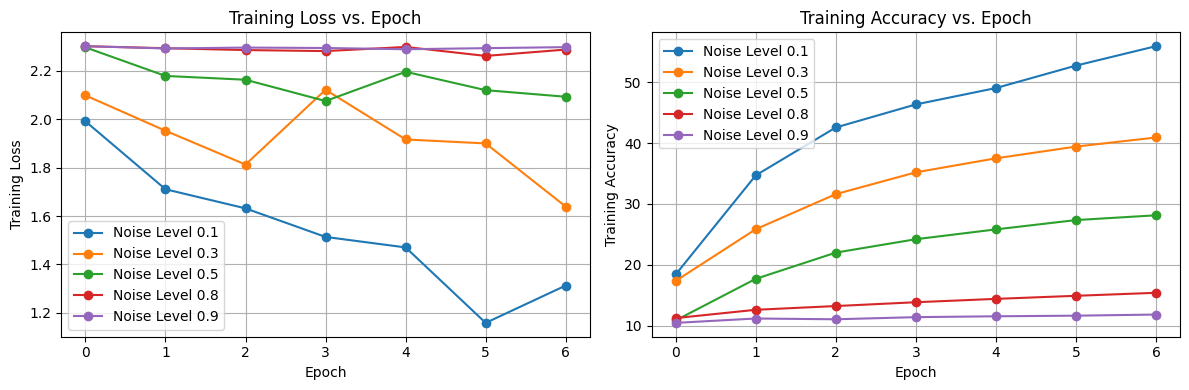

In [23]:
# plot training loss & accuracy for each noise level
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
for epsilon, losses in train_losses.items():
    plt.plot(losses, label=f'Noise Level {epsilon}', marker='o')

plt.title('Training Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for epsilon, accuracies in train_accuracies.items():
    plt.plot(accuracies, label=f'Noise Level {epsilon}', marker='o')

plt.title('Training Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
test_accuracies = []
testing_times = []

# testing
for key, model_state_info in model_dict.items():
    model = BaselineModel()
    model_state = model.state_dict()
    model_state.update({k: v for k, v in model_state_info['state_dict'].items() if k in model_state})

    # load the updated state_dict
    model.load_state_dict(model_state)

    model = model.to(device)
    model.eval()

    correct = 0
    total = 0

    # initialize variables to measure testing time
    start_time_test = time.time()

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # measure testing time
    total_test_time = time.time() - start_time_test
    testing_times.append(total_test_time)
    print(f'Total Testing Time for {key}: {total_test_time:.2f} seconds')

    # calculate test accuracy
    accuracy = correct / total
    test_accuracies.append(accuracy)
    print(f'Test Accuracy for {key}: {accuracy}')

# print the total time for the entire testing process
total_testing_process_time = sum(testing_times)
print(f'Total Testing Process Time: {total_testing_process_time:.2f} seconds')

In [ ]:
# plot testing accuracy and time
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(noise_levels, test_accuracies, marker='o')
plt.title('Testing Accuracy vs. Noise Level')
plt.xlabel('Noise Level')
plt.ylabel('Accuracy')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(noise_levels,  testing_times, marker='o')
plt.title('Testing Time vs. Noise Level')
plt.xlabel('Noise Level')
plt.ylabel('Testing Time (seconds)')
plt.grid(True)

plt.tight_layout()
plt.show()

## Train & Validation and Testing - asymmetric noise label

In [15]:
# noise levels
noise_levels = [0.1, 0.3, 0.5, 0.8, 0.9]

# create a dictionary with keys in the format 'noise_level_{100 * value}'
model_dict = {f'noise_level_{int(100 * level)}_asy': None for level in noise_levels}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# initialize lists to store metrics
train_losses = {epsilon: [] for epsilon in noise_levels}
train_accuracies = {epsilon: [] for epsilon in noise_levels}
val_losses = {epsilon: [] for epsilon in noise_levels}
val_accuracies = {epsilon: [] for epsilon in noise_levels}
training_times = []
validation_times = []

# training
for epsilon in noise_levels:

    num_epochs = 5

    model = BaselineModel()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    model = model.to(device)
    model.train()

    print(f"Asymmetric Training with noise level: {epsilon}")

    # initialize variables to measure training time
    start_time_train = time.time()

    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        total_correct = 0
        total_samples = 0

        for inputs, labels in train_loader:

            # add asymmetric noise to labels
            labels = apply_label_noise(labels.numpy(), epsilon=epsilon, noise_type='asymmetric')
            labels = torch.from_numpy(labels)

            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            # calculate training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()

        # measure and print epoch training time
        epoch_time = time.time() - epoch_start_time
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}, Training Time: {epoch_time:.2f}')

        # store training metrics
        train_losses[epsilon].append(loss.item())
        train_accuracies[epsilon].append(100 * total_correct / total_samples)

    # store total training time
    total_train_time = time.time() - start_time_train
    training_times.append(total_train_time)
    print(f'Total Training Time for noise level {epsilon}: {total_train_time:.2f} seconds')

    # validation
    model.eval()

    # initialize variables to measure validation time
    start_time_val = time.time()

    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

            # calculate validation accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # measure and print validation time
    total_val_time = time.time() - start_time_val
    validation_times.append(total_val_time)
    print(f'Total Validation Time for noise level {epsilon}: {total_val_time:.2f} seconds')

    # store validation metrics
    val_accuracy = correct / total
    average_val_loss = val_loss / len(val_loader)
    val_losses[epsilon].append(average_val_loss)
    val_accuracies[epsilon].append(val_accuracy)

    print(f'Validation Loss: {average_val_loss}, Validation Accuracy: {val_accuracy}')

    # save model to dictionary
    model_dict[f'noise_level_{int(100 * epsilon)}_asy'] = {
        'state_dict': model.state_dict(),
        'validation_loss': average_val_loss,
        'validation_accuracy': val_accuracy
    }

# print the total time for the entire training process
total_training_process_time = sum(training_times) + sum(validation_times)
print(f'Total Training Process Time: {total_training_process_time:.2f} seconds')

Asymmetric Training with noise level: 0.1
Epoch 1/5, Loss: 2.3011786937713623, Training Time: 16.87
Epoch 2/5, Loss: 2.270972967147827, Training Time: 16.14
Epoch 3/5, Loss: 2.067095994949341, Training Time: 16.01
Epoch 4/5, Loss: 1.749006986618042, Training Time: 16.24
Epoch 5/5, Loss: 1.7283658981323242, Training Time: 16.65
Total Training Time for noise level 0.1: 81.93 seconds
Total Validation Time for noise level 0.1: 3.24 seconds
Validation Loss: 1.614984758340629, Validation Accuracy: 0.4124
Asymmetric Training with noise level: 0.3
Epoch 1/5, Loss: 2.2726800441741943, Training Time: 17.36
Epoch 2/5, Loss: 2.286006450653076, Training Time: 16.68
Epoch 3/5, Loss: 2.276057243347168, Training Time: 16.10
Epoch 4/5, Loss: 1.9092481136322021, Training Time: 16.46
Epoch 5/5, Loss: 1.9092283248901367, Training Time: 16.43
Total Training Time for noise level 0.3: 83.04 seconds
Total Validation Time for noise level 0.3: 3.81 seconds
Validation Loss: 1.9070420819482985, Validation Accurac

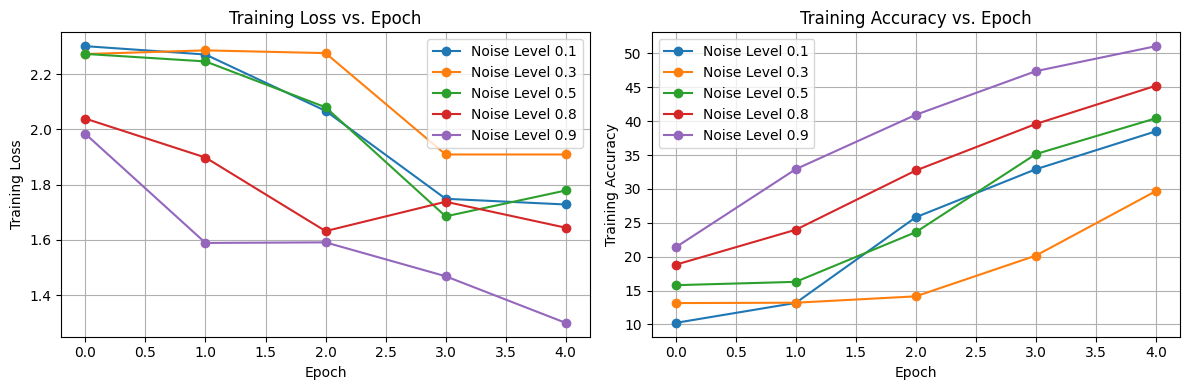

In [16]:
# plot training loss & accuracy for each noise level
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
for epsilon, losses in train_losses.items():
    plt.plot(losses, label=f'Noise Level {epsilon}', marker='o')

plt.title('Training Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for epsilon, accuracies in train_accuracies.items():
    plt.plot(accuracies, label=f'Noise Level {epsilon}', marker='o')

plt.title('Training Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [17]:
test_accuracies = []
testing_times = []

# testing
for key, model_state_info in model_dict.items():
    model = BaselineModel()
    model_state = model.state_dict()
    model_state.update({k: v for k, v in model_state_info['state_dict'].items() if k in model_state})

    # load the updated state_dict
    model.load_state_dict(model_state)

    model = model.to(device)
    model.eval()

    correct = 0
    total = 0

    # initialize variables to measure testing time
    start_time_test = time.time()

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # measure and print testing time
    total_test_time = time.time() - start_time_test
    testing_times.append(total_test_time)
    print(f'Total Testing Time for {key}: {total_test_time:.2f} seconds')

    # calculate test accuracy
    accuracy = correct / total
    test_accuracies.append(accuracy)
    print(f'Test Accuracy for {key}: {accuracy}')


Total Testing Time for noise_level_10_asy: 3.14 seconds
Test Accuracy for noise_level_10_asy: 0.4248
Total Testing Time for noise_level_30_asy: 3.15 seconds
Test Accuracy for noise_level_30_asy: 0.3041
Total Testing Time for noise_level_50_asy: 4.08 seconds
Test Accuracy for noise_level_50_asy: 0.347
Total Testing Time for noise_level_80_asy: 3.62 seconds
Test Accuracy for noise_level_80_asy: 0.3257
Total Testing Time for noise_level_90_asy: 3.18 seconds
Test Accuracy for noise_level_90_asy: 0.3594


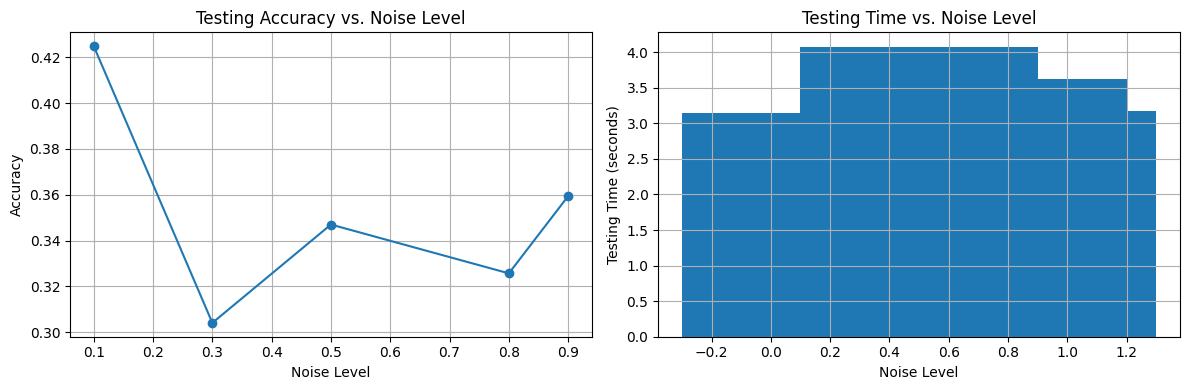

In [21]:
# plot testing accuracy and time
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(noise_levels, test_accuracies, marker='o')
plt.title('Testing Accuracy vs. Noise Level')
plt.xlabel('Noise Level')
plt.ylabel('Accuracy')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(noise_levels,  testing_times, marker='o')
plt.title('Testing Time vs. Noise Level')
plt.xlabel('Noise Level')
plt.ylabel('Testing Time (seconds)')
plt.grid(True)

plt.tight_layout()
plt.show()

# Applying dynamic weights of samples to the BaselineModel

- use compute_sample_weights(), and integrate the weighted loss calculation into the training loop


---



*hyper parameter tuning*

1.   num of epoch
2.   threshold in compute_sample_weights() : Starting with a low threshold and gradually increasing it to observe how the model's performance changes.




In [27]:
# compute sample weights based on prediction confidence with threshold
def compute_sample_weights(outputs, labels, threshold=0.6):
    confidences, _ = torch.max(nn.functional.softmax(outputs, dim=1), dim=1)
    weights = torch.where(confidences < threshold, torch.tensor(1.0), 1.0 / confidences)
    return weights

## Symmetric

In [29]:
# noise levels
noise_levels = [0.1, 0.3, 0.5, 0.8, 0.9]

# create a dictionary with keys in the format 'noise_level_{100 * value}'
model_dict = {f'noise_level_{int(100 * level)}_sy': None for level in noise_levels}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# initialize lists to store metrics
train_losses = {epsilon: [] for epsilon in noise_levels}
train_accuracies = {epsilon: [] for epsilon in noise_levels}
val_losses = {epsilon: [] for epsilon in noise_levels}
val_accuracies = {epsilon: [] for epsilon in noise_levels}
training_times = []
validation_times = []

# training
for epsilon in noise_levels:
    num_epochs = 5

    model = BaselineModel()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    model = model.to(device)
    model.train()

    print(f"Symmetric Training with noise level: {epsilon}")

    # initialize variables to measure training time
    start_time_train = time.time()

    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        total_correct = 0
        total_samples = 0

        for inputs, labels in train_loader:

            # add symmetric noise to labels
            labels = apply_label_noise(labels.numpy(), epsilon=epsilon, noise_type='symmetric')
            labels = torch.from_numpy(labels)

            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            weights = compute_sample_weights(outputs, labels)  # compute sample weights

            # Apply weights manually to the loss
            loss = torch.sum(weights * criterion(outputs, labels)) / len(labels)

            loss.backward()
            optimizer.step()

            # calculate training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()

        # measure and print epoch training time
        epoch_time = time.time() - epoch_start_time
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}, Training Time: {epoch_time:.2f}')

        # store training metrics
        train_losses[epsilon].append(loss.item())
        train_accuracies[epsilon].append(100 * total_correct / total_samples)

    # store total training time
    total_train_time = time.time() - start_time_train
    training_times.append(total_train_time)
    print(f'Total Training Time for noise level {epsilon}: {total_train_time:.2f} seconds')

    # validation
    model.eval()

    # initialize variables to measure validation time
    start_time_val = time.time()

    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

            # calculate validation accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # measure and print validation time
    total_val_time = time.time() - start_time_val
    validation_times.append(total_val_time)
    print(f'Total Validation Time for noise level {epsilon}: {total_val_time:.2f} seconds')

    # store validation metrics
    val_accuracy = correct / total
    average_val_loss = val_loss / len(val_loader)
    val_losses[epsilon].append(average_val_loss)
    val_accuracies[epsilon].append(val_accuracy)

    print(f'Validation Loss: {average_val_loss}, Validation Accuracy: {val_accuracy}')

    # save model to dictionary
    model_dict[f'noise_level_{int(100 * epsilon)}_sy'] = {
        'state_dict': model.state_dict(),
        'validation_loss': average_val_loss,
        'validation_accuracy': val_accuracy
    }

# print the total time for the entire training process
total_training_process_time = sum(training_times) + sum(validation_times)
print(f'Total Training Process Time: {total_training_process_time:.2f} seconds')


Symmetric Training with noise level: 0.1
Epoch 1/5, Loss: 2.2990634441375732, Training Time: 19.15
Epoch 2/5, Loss: 2.088263988494873, Training Time: 20.64
Epoch 3/5, Loss: 1.9768149852752686, Training Time: 18.26
Epoch 4/5, Loss: 2.13104248046875, Training Time: 17.29
Epoch 5/5, Loss: 2.0810437202453613, Training Time: 21.58
Total Training Time for noise level 0.1: 96.93 seconds
Total Validation Time for noise level 0.1: 3.30 seconds
Validation Loss: 1.637932708308955, Validation Accuracy: 0.4366
Symmetric Training with noise level: 0.3
Epoch 1/5, Loss: 2.305569887161255, Training Time: 27.36
Epoch 2/5, Loss: 2.2789254188537598, Training Time: 18.08
Epoch 3/5, Loss: 2.0445284843444824, Training Time: 18.23
Epoch 4/5, Loss: 2.184591293334961, Training Time: 17.36
Epoch 5/5, Loss: 2.0544228553771973, Training Time: 17.39
Total Training Time for noise level 0.3: 98.42 seconds
Total Validation Time for noise level 0.3: 4.19 seconds
Validation Loss: 1.8981313082822568, Validation Accuracy:

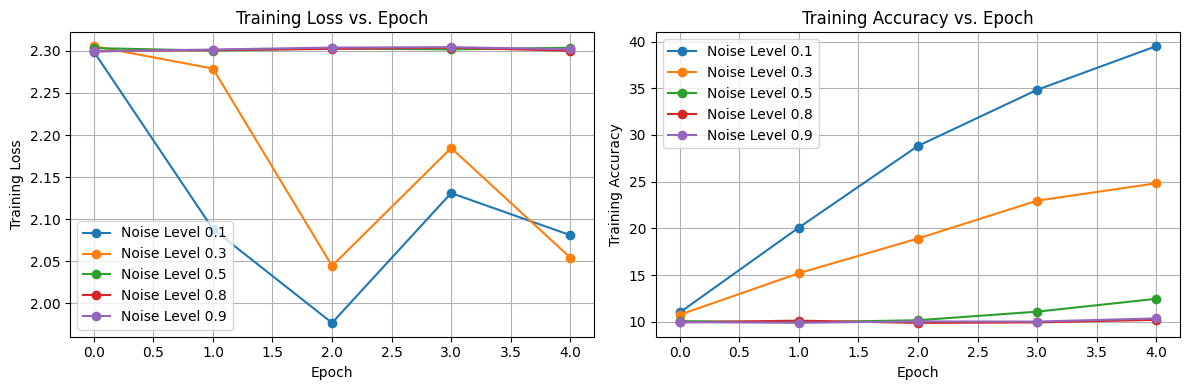

In [30]:
# plot training loss & accuracy for each noise level
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
for epsilon, losses in train_losses.items():
    plt.plot(losses, label=f'Noise Level {epsilon}', marker='o')

plt.title('Training Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for epsilon, accuracies in train_accuracies.items():
    plt.plot(accuracies, label=f'Noise Level {epsilon}', marker='o')

plt.title('Training Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [31]:
test_accuracies = []
testing_times = []

# testing
for key, model_state_info in model_dict.items():
    model = BaselineModel()
    model_state = model.state_dict()
    model_state.update({k: v for k, v in model_state_info['state_dict'].items() if k in model_state})

    # load the updated state_dict
    model.load_state_dict(model_state)

    model = model.to(device)
    model.eval()

    correct = 0
    total = 0

    # initialize variables to measure testing time
    start_time_test = time.time()

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # measure testing time
    total_test_time = time.time() - start_time_test
    testing_times.append(total_test_time)
    print(f'Total Testing Time for {key}: {total_test_time:.2f} seconds')

    # calculate test accuracy
    accuracy = correct / total
    test_accuracies.append(accuracy)
    print(f'Test Accuracy for {key}: {accuracy}')

# print the total time for the entire testing process
total_testing_process_time = sum(testing_times)
print(f'Total Testing Process Time: {total_testing_process_time:.2f} seconds')


Total Testing Time for noise_level_10_sy: 3.34 seconds
Test Accuracy for noise_level_10_sy: 0.4411
Total Testing Time for noise_level_30_sy: 3.30 seconds
Test Accuracy for noise_level_30_sy: 0.3295
Total Testing Time for noise_level_50_sy: 4.22 seconds
Test Accuracy for noise_level_50_sy: 0.1752
Total Testing Time for noise_level_80_sy: 3.34 seconds
Test Accuracy for noise_level_80_sy: 0.12
Total Testing Time for noise_level_90_sy: 3.29 seconds
Test Accuracy for noise_level_90_sy: 0.1
Total Testing Process Time: 17.49 seconds


In [ ]:
# plot testing accuracy and time
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(noise_levels, test_accuracies, marker='o')
plt.title('Testing Accuracy vs. Noise Level')
plt.xlabel('Noise Level')
plt.ylabel('Accuracy')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.bar(noise_levels, testing_times)
plt.title('Testing Time vs. Noise Level')
plt.xlabel('Noise Level')
plt.ylabel('Testing Time (seconds)')
plt.grid(True)

plt.tight_layout()
plt.show()

## Asymmetric